In [1]:
from yako_util import util as q
from yako_util import era5 as era5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
import sklearn
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from metpy.constants import g
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from torch.utils.data import DataLoader, TensorDataset
import torch
import random
from xgboost import XGBRegressor

In [2]:
np.random.seed(132)
random.seed(132)

np.set_printoptions(suppress=True, precision=3)
torch.use_deterministic_algorithms(True)

## Load dataset

In [3]:
files = sorted(
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2014') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2015') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2016') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2017') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2018')
)

tc_gmi_files = sorted(list(filter(lambda x: 'gmi_tc' in x, files)))
tc_sim_scatt_files = sorted(list(filter(lambda x: 'Tc_hydro_13ch' in x, files)))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))

specific_humidity_files = sorted(list(filter(lambda x: 'era5_specific_humidity' in x, files)))
temperature_files = sorted(list(filter(lambda x: 'era5_temperature' in x, files)))
surface_pressure_files = sorted(list(filter(lambda x: 'surface_pressure' in x, files)))
tm_temperature_files = sorted(list(filter(lambda x: 'era5_2m_temperature' in x, files)))
tm_dewpoint_temperature_files = sorted(list(filter(lambda x: 'era5_2m_dewpoint_temperature' in x, files)))
skin_temperature_files = sorted(list(filter(lambda x: 'era5_skin_temperature' in x, files)))

cloud_liquid_water_files = sorted(list(filter(lambda x: 'era5_cloud_liqud_water' in x, files)))
cloud_ice_water_files = sorted(list(filter(lambda x: 'era5_cloud_ice_water' in x, files)))
precip_liquid_water_files = sorted(list(filter(lambda x: 'era5_precip_liquid_water' in x, files)))
precip_ice_water_files = sorted(list(filter(lambda x: 'era5_precip_ice_water' in x, files)))

landsea_telsem_files = sorted(list(filter(lambda x: 'landsea_telsem' in x, files)))

es_files = sorted(list(filter(lambda x: 'es_telsem_13ch' in x, files)))

lat_files = sorted(list(filter(lambda x: 'gmi_lat' in x, files)))
lon_files = sorted(list(filter(lambda x: 'gmi_lon' in x, files)))

autosnow_files = sorted(list(filter(lambda x: 'autosnow' in x, files)))

In [4]:
tc_gmi = np.concatenate(list(map(np.load, tc_gmi_files)), axis=0)
tc_sim_scatt = np.concatenate(list(map(np.load, tc_sim_scatt_files)), axis=0)
tc_sim_clear = np.concatenate(list(map(np.load, tc_sim_clear_files)), axis=0)

lat = np.concatenate(list(map(np.load, lat_files)), axis=0)
lon = np.concatenate(list(map(np.load, lon_files)), axis=0)

pressure = np.tile(era5.get_pressure_levels()[::-1], (tc_gmi.shape[0], 1))
nprofiles = pressure.shape[0]
nlevels = pressure.shape[1]

surface_pressure = np.concatenate(list(map(np.load, surface_pressure_files)), axis=0).reshape(nprofiles)
tm_temperature = np.concatenate(list(map(np.load, tm_temperature_files)), axis=0).reshape(nprofiles)
tm_dewpoint_temperature = np.concatenate(list(map(np.load, tm_dewpoint_temperature_files)), axis=0).reshape(nprofiles)
skin_temperature = np.concatenate(list(map(np.load, skin_temperature_files)), axis=0).reshape(nprofiles)
autosnow = np.concatenate(list(map(np.load, autosnow_files)), axis=0).reshape(nprofiles)

specific_humidity = np.concatenate(list(map(np.load, specific_humidity_files)), axis=0).reshape(nprofiles, nlevels)
temperature = np.concatenate(list(map(np.load, temperature_files)), axis=0).reshape(nprofiles, nlevels)
cloud_liquid_water = np.concatenate(list(map(np.load, cloud_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
cloud_ice_water = np.concatenate(list(map(np.load, cloud_ice_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_liquid_water = np.concatenate(list(map(np.load, precip_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_ice_water = np.concatenate(list(map(np.load, precip_ice_water_files)), axis=0).reshape(nprofiles, nlevels)

es = np.concatenate(list(map(np.load, es_files)), axis=0).reshape(nprofiles, 13)
landsea_telsem = np.concatenate(list(map(np.load, landsea_telsem_files)), axis=0).reshape(nprofiles)

In [5]:
mixing_ratio = mixing_ratio_from_specific_humidity(specific_humidity * units('kg/kg')).to('g/kg')
moist_air_density = density(pressure * units.hPa, temperature * units.K, mixing_ratio).to('kg/m3')

qr_avg = (precip_liquid_water[:,:-1] + precip_liquid_water[:,1:]) / 2
qi_avg = (precip_ice_water[:,:-1] + precip_ice_water[:,1:]) / 2
qc_avg = (cloud_liquid_water[:,:-1] + cloud_liquid_water[:,1:]) / 2
qci_avg = (cloud_ice_water[:,:-1] + cloud_ice_water[:,1:]) / 2

dp = -np.diff((pressure*units.hPa).to(units.Pa), axis=1)
tcwv = np.sum(((qr_avg + qi_avg + qc_avg + qci_avg) * dp) / g, axis=1).to('kg/m2').m

0 - water only \
1 - land only \
2 - snow land only \
3 - ice only \
4 - frozen sea (ice and water) \
5 - beach (land and water) \
6 - frozen beach (snow/land and water/ice) \
7 - glacier (snow/land and ice)

In [6]:
valid_mask = (
    np.all(tc_gmi >= 50, axis=1) &
    np.all(tc_gmi <= 500, axis=1) &
    np.all(tc_sim_scatt >= 50, axis=1) &
    np.all(tc_sim_scatt <= 500, axis=1) &
    np.all(tc_sim_clear >= 50, axis=1) &
    np.all(tc_sim_clear <= 500, axis=1)
)

telsem_surf = landsea_telsem == 1
telsem_water = landsea_telsem == 0

sea_mask = autosnow == 0
land_mask = autosnow == 1
snow_mask = autosnow == 2
ice_mask = autosnow == 3
frozen_sea_mask = autosnow == 4
beach_mask = (autosnow == 5) | (autosnow == 6)
glacier_mask = autosnow == 7

clear_sky_mask = tcwv <= 0.015

lat_mask = (lat >= 40) | (lat <= -40)

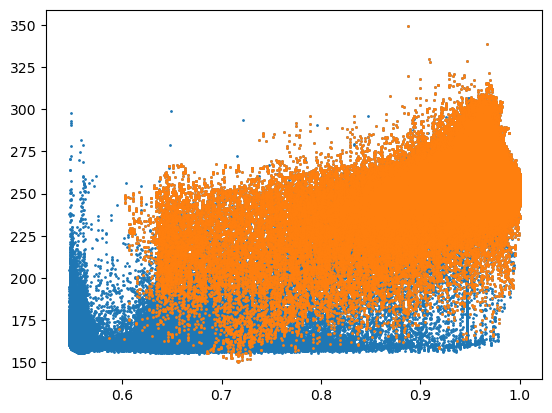

In [7]:
plt.scatter(es[valid_mask&lat_mask,0], tc_gmi[valid_mask&lat_mask,0], s=1)
plt.scatter(es[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], tc_gmi[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], s=1)
# plt.scatter(es[valid_mask&telsem_surf,0], tc_gmi[valid_mask&telsem_surf,0], s=1)
# plt.scatter(es[valid_mask&telsem_water,0], tc_gmi[valid_mask&telsem_water,0], s=1)

In [8]:
channels = q.gmi_channels()

# Direct models

In [9]:
features = np.array([
    *(tc_gmi.T),
    # tcwv,
    surface_pressure,
    tm_dewpoint_temperature,
    tm_temperature,
    # skin_temperature,
    # autosnow,
]).T

labels = es[:,:]

feature_names = [
    *[f'Tc_{i}' for i in range(1, 14)],
    'surf pressure',
    't2m dewpoint temp',
    't2m temp',
    # 'skin temp',
    # 'autosnow',
]

In [10]:
# train_mask = np.array([True]*int(len(features)*split) + [False]*(len(features) - int(len(features)*split)))
train_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.7, 0.3])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)
# train_mask = np.random.rand(features.shape[0]) < 0.7
test_mask = ~train_mask

use_data_mask = valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask
train_mask = train_mask & use_data_mask
test_mask = test_mask & use_data_mask

use_clear_sky_mask = clear_sky_mask[use_data_mask]

## Poly model

In [541]:
poly_features = PolynomialFeatures(degree=3)
X_train = poly_features.fit_transform(features[train_mask])
X_test = poly_features.transform(features[test_mask])
X = poly_features.transform(features[use_data_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [542]:
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [543]:
lin_reg.estimators_[0].coef_

array([-0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0.,
       -0., -0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.,
       -0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,
        0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0

In [544]:
P_train = np.clip(lin_reg.predict(X_train), 0, 1)
P_test = np.clip(lin_reg.predict(X_test), 0, 1)
P = np.clip(lin_reg.predict(X), 0, 1)

In [545]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.025 0.04  0.025 0.04  0.025 0.027 0.039 0.03  0.037 0.03  0.035 0.03
 0.03 ]
[0.027 0.043 0.027 0.043 0.026 0.028 0.041 0.03  0.038 0.03  0.035 0.03
 0.03 ]
[0.029 0.057 0.029 0.057 0.028 0.031 0.052 0.035 0.047 0.035 0.043 0.035
 0.035]
[0.031 0.064 0.031 0.064 0.03  0.032 0.057 0.035 0.049 0.035 0.044 0.035
 0.035]


Text(0.5, 0.98, 'MAE - Poly')

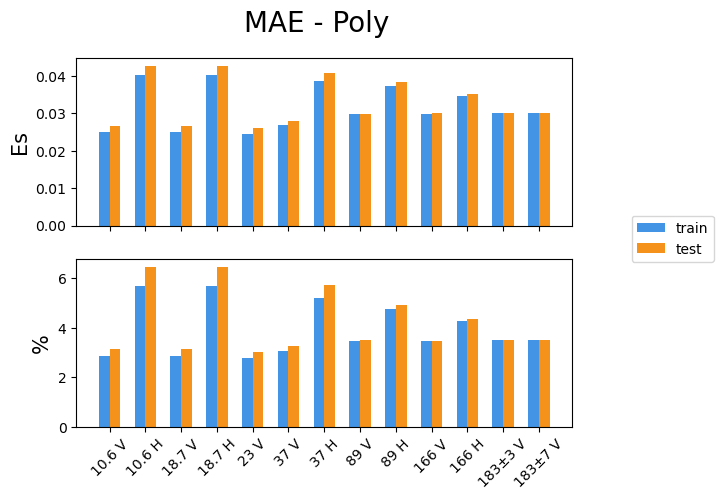

In [546]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - Poly', fontsize=20)

In [547]:
_lin_p_test = P_test

## XGBOOST

In [11]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [17]:
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=132,
)

xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=132, ...)

In [18]:
P_train = np.clip(xgb_reg.predict(X_train), 0, 1)
P_test = np.clip(xgb_reg.predict(X_test), 0, 1)
P = np.clip(xgb_reg.predict(X), 0, 1)

In [19]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.015 0.024 0.015 0.025 0.015 0.017 0.024 0.018 0.024 0.018 0.022 0.018
 0.018]
[0.023 0.037 0.023 0.037 0.022 0.024 0.036 0.025 0.034 0.026 0.031 0.026
 0.026]
[0.017 0.033 0.017 0.033 0.017 0.019 0.031 0.021 0.03  0.021 0.027 0.021
 0.021]
[0.027 0.056 0.027 0.056 0.026 0.028 0.051 0.03  0.043 0.03  0.038 0.03
 0.03 ]


Text(0.5, 0.98, 'MAE - GBRT')

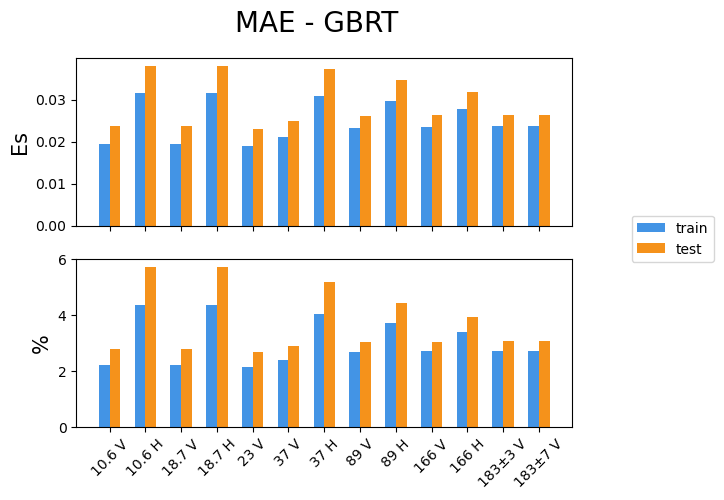

In [559]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [24]:
_xgb_p_test = P_test

## GBRT model

In [463]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [464]:
gbrt_reg = MultiOutputRegressor(HistGradientBoostingRegressor(verbose=1))
gbrt_reg.fit(X_train, Y_train)

Binning 0.020 GB of training data: 

0.242 s
Binning 0.002 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.00173, val loss: 0.00175, in 0.008s
[2/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.00156, val loss: 0.00158, in 0.005s
[3/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.00141, val loss: 0.00143, in 0.005s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.00129, val loss: 0.00131, in 0.005s
[5/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00119, val loss: 0.00122, in 0.005s
[6/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00111, val loss: 0.00113, in 0.005s
[7/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00104, val loss: 0.00107, in 0.005s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.00098, val loss: 0.00101, in 0.005s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.00093, val loss: 0.00097, in 0.005s
[10/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.00089, val loss: 0.00093, in

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(verbose=1))

In [465]:
# sorted(list(zip(gbrt_reg.estimators_[0].feature_importances_, feature_names)), reverse=True)

In [466]:
P_train = np.clip(gbrt_reg.predict(X_train), 0, 1)
P_test = np.clip(gbrt_reg.predict(X_test), 0, 1)
P = np.clip(gbrt_reg.predict(X), 0, 1)

In [467]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.019 0.031 0.019 0.031 0.019 0.021 0.031 0.023 0.03  0.023 0.028 0.023
 0.023]
[0.023 0.038 0.023 0.038 0.023 0.025 0.037 0.026 0.035 0.026 0.032 0.026
 0.026]
[0.022 0.043 0.022 0.043 0.021 0.024 0.04  0.027 0.037 0.027 0.034 0.027
 0.027]
[0.027 0.057 0.027 0.057 0.027 0.029 0.052 0.031 0.045 0.031 0.039 0.031
 0.031]


Text(0.5, 0.98, 'MAE - GBRT')

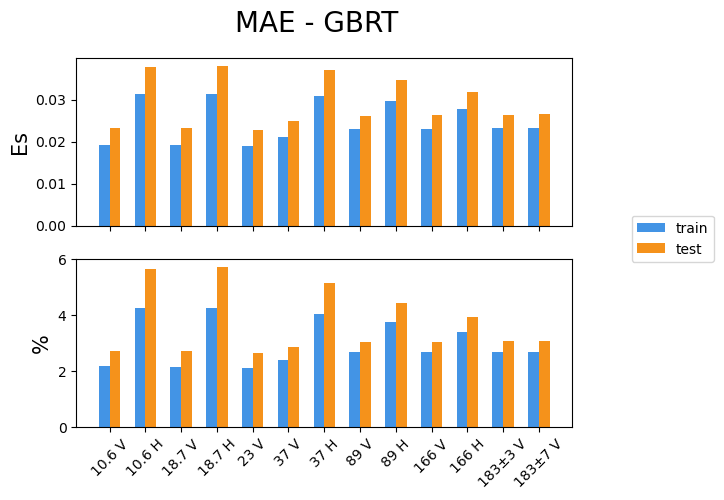

In [468]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [469]:
_gbrt_p_test = P_test

## NN model

In [470]:
val_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.3, 0.7])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)

X_train = features[train_mask&(~val_mask)]
X_test = features[test_mask]
X_val = features[train_mask&(val_mask)]
X = features[use_data_mask]

Y_train = labels[train_mask&(~val_mask)]
Y_test = labels[test_mask]
Y_val = labels[train_mask&(val_mask)]
Y = labels[use_data_mask]

In [491]:
min_max = np.array([
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [40000, 150000],
    [200, 350],
    [200, 350],
    # [0, 7],
    # [0, 0.25],
])

X_train_norm = (X_train - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_test_norm = (X_test - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_val_norm = (X_val - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_norm = (X - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
# X_train_norm = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_test_norm = (X_test - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_val_norm = (X_val - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_norm = (X - X_train.mean(axis=0)) / (X_train.std(axis=0))

Y_train_norm = np.clip(2*(Y_train - 0.5), 0, 1)
Y_test_norm = np.clip(2*(Y_test - 0.5), 0, 1)
Y_val_norm = np.clip(2*(Y_val - 0.5), 0, 1)
Y_norm = np.clip(2*(Y - 0.5), 0, 1)

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train_norm), torch.Tensor(Y_train_norm)), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test_norm), torch.Tensor(Y_test_norm)), batch_size=256)
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val_norm), torch.Tensor(Y_val_norm)), batch_size=256)

In [493]:
import direct
from importlib import reload
reload(direct)

model = direct.SimpleNN()

early_stopper = direct.EarlyStopping(patience=10)
trainer = direct.ModelTrainer(model, early_stopper=early_stopper, lr=0.001)

trainer.train(train_loader, val_loader, epochs=1000)
trainer.test(test_loader)

Epoch 1/1000, Train Loss: 0.0158, Val Loss: 0.0083
Epoch 2/1000, Train Loss: 0.0078, Val Loss: 0.0075
Epoch 3/1000, Train Loss: 0.0073, Val Loss: 0.0072
Epoch 4/1000, Train Loss: 0.0071, Val Loss: 0.0074
Epoch 5/1000, Train Loss: 0.0069, Val Loss: 0.0072
Epoch 6/1000, Train Loss: 0.0067, Val Loss: 0.0075
Epoch 7/1000, Train Loss: 0.0066, Val Loss: 0.0072
Epoch 8/1000, Train Loss: 0.0065, Val Loss: 0.0072
Epoch 9/1000, Train Loss: 0.0064, Val Loss: 0.0072
Epoch 10/1000, Train Loss: 0.0063, Val Loss: 0.0072
Epoch 11/1000, Train Loss: 0.0060, Val Loss: 0.0069
Epoch 12/1000, Train Loss: 0.0060, Val Loss: 0.0069
Epoch 13/1000, Train Loss: 0.0060, Val Loss: 0.0069
Epoch 14/1000, Train Loss: 0.0060, Val Loss: 0.0070
Epoch 15/1000, Train Loss: 0.0060, Val Loss: 0.0069
Epoch 16/1000, Train Loss: 0.0059, Val Loss: 0.0069
Epoch 17/1000, Train Loss: 0.0059, Val Loss: 0.0069
Epoch 18/1000, Train Loss: 0.0059, Val Loss: 0.0069
Epoch 19/1000, Train Loss: 0.0059, Val Loss: 0.0070
Epoch 20/1000, Train 

KeyboardInterrupt: 

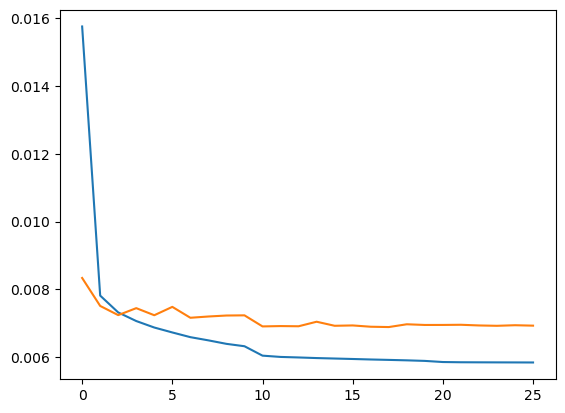

In [497]:
plt.plot(trainer.train_hist[:])
plt.plot(trainer.val_hist[:])

In [495]:
with torch.no_grad():
    P_train = np.clip(model(torch.Tensor(X_train_norm)).numpy()/2+0.5, 0, 1)
    P_test = np.clip(model(torch.Tensor(X_test_norm)).numpy()/2+0.5, 0, 1)
    P = np.clip(model(torch.Tensor(X_norm)).numpy()/2+0.5, 0, 1)

In [496]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.02  0.033 0.02  0.033 0.019 0.021 0.031 0.022 0.029 0.023 0.027 0.023
 0.023]
[0.023 0.038 0.023 0.038 0.022 0.024 0.036 0.026 0.033 0.026 0.031 0.026
 0.026]
[0.023 0.047 0.023 0.047 0.022 0.024 0.042 0.026 0.037 0.027 0.033 0.027
 0.027]
[0.027 0.057 0.027 0.057 0.026 0.028 0.051 0.03  0.043 0.03  0.038 0.03
 0.03 ]


Text(0.5, 0.98, 'MAE - NN')

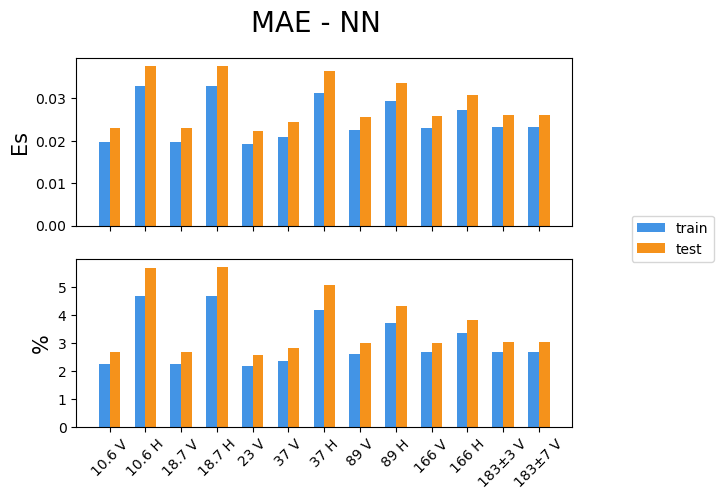

In [498]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - NN', fontsize=20)

In [499]:
_nn_p_test = P_test

## Post analysis

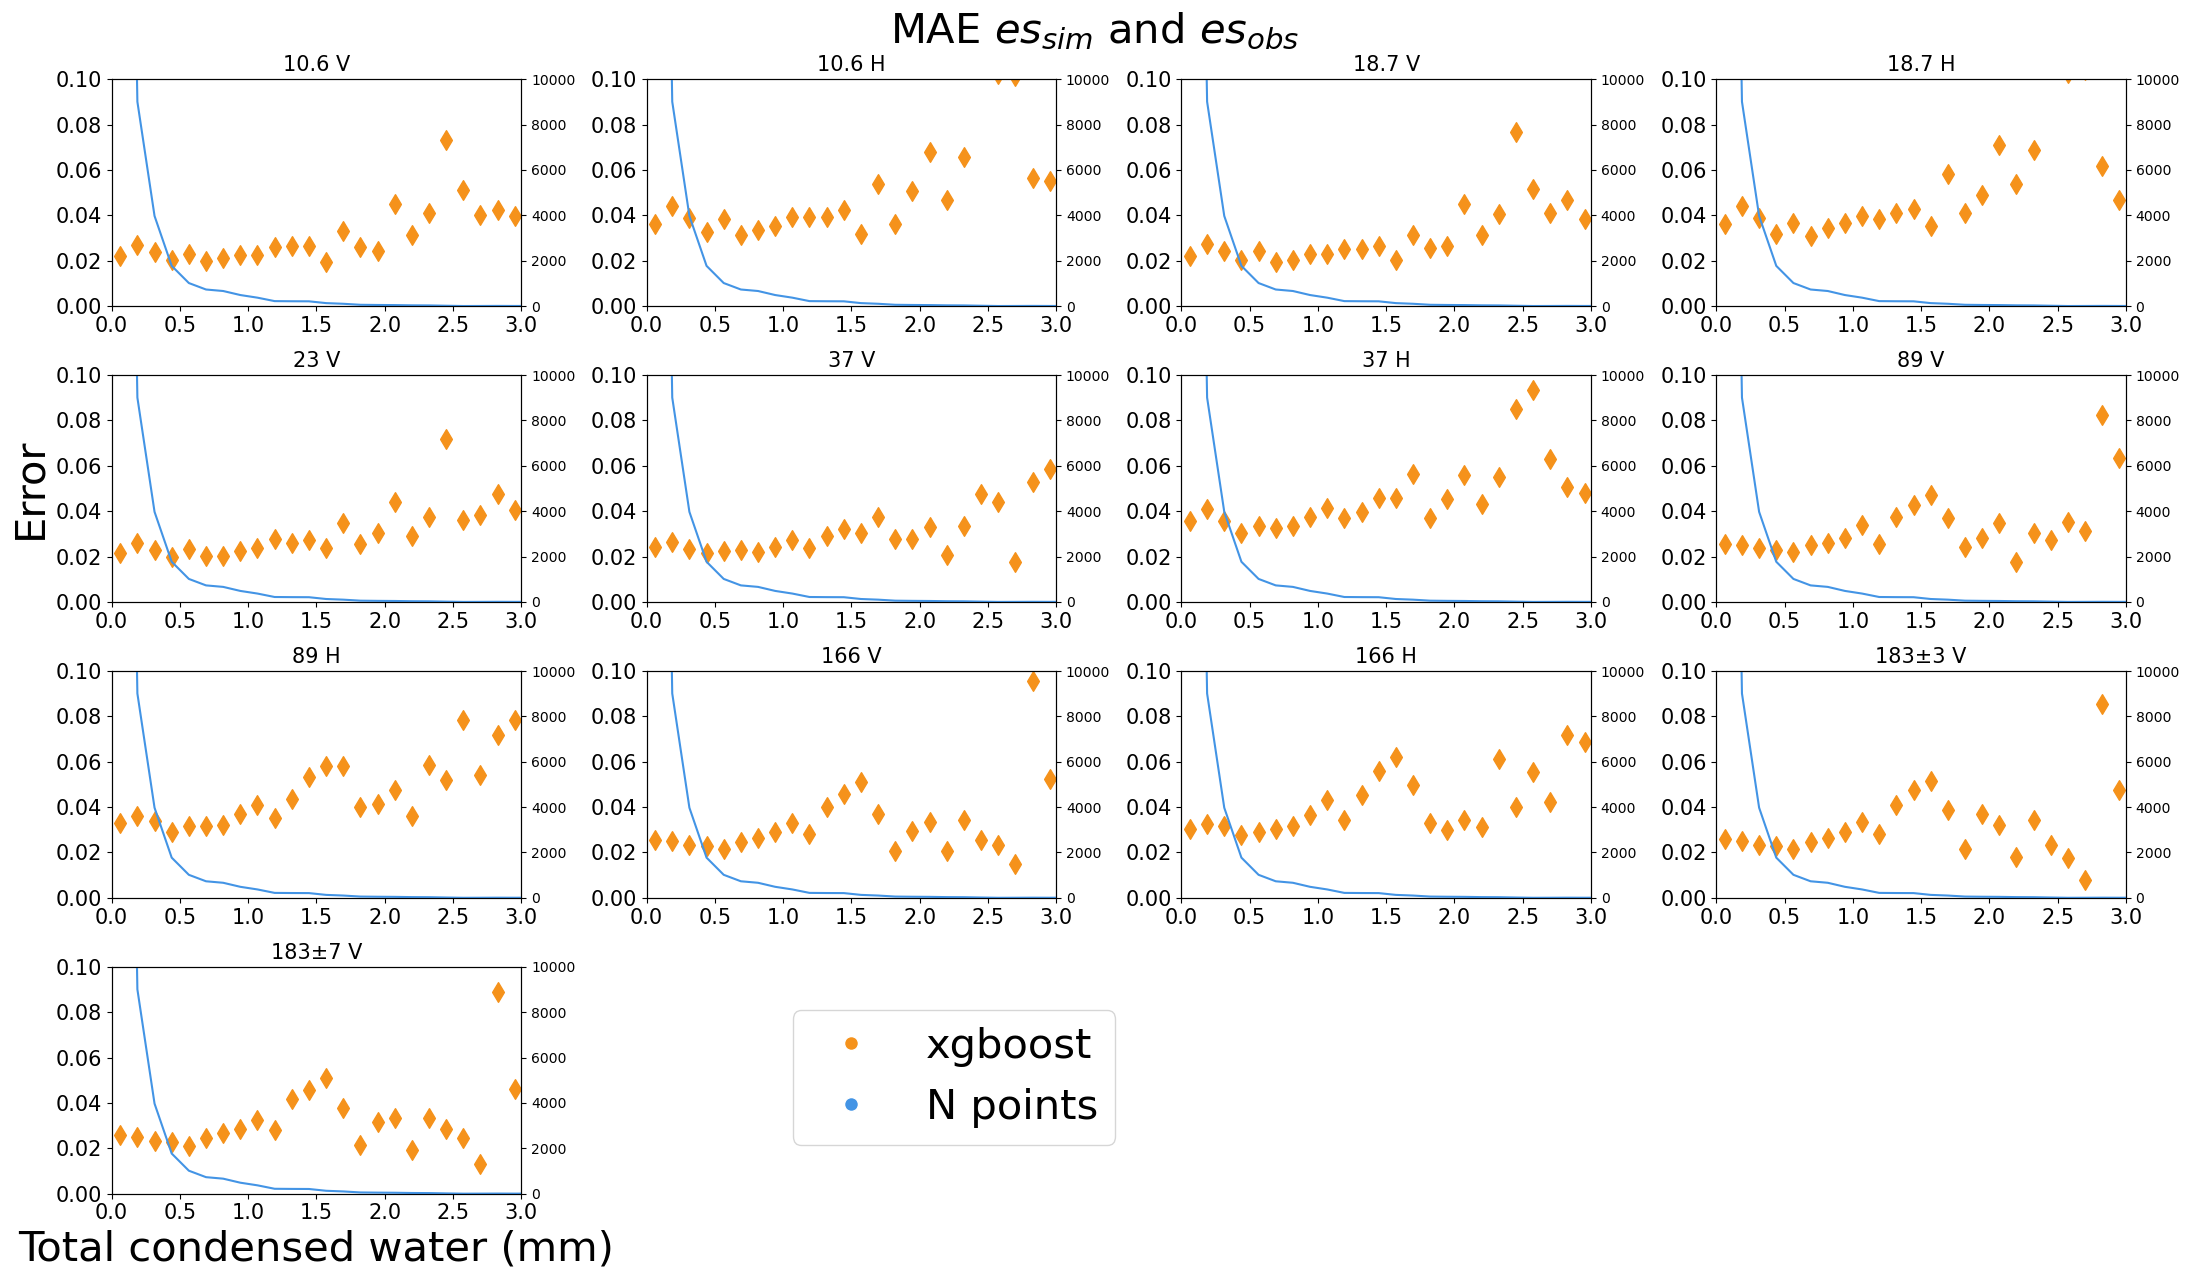

In [48]:
use_mask = land_mask | snow_mask | ice_mask

nbins = 100

bins = np.linspace(tcwv[use_mask].min(), tcwv[use_mask].max(), nbins+1)

error_xgboost = _xgb_p_test - Y_test

bin_indices = np.digitize(tcwv[use_data_mask&test_mask], bins) - 1

plt.figure(figsize=(22, 13))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    avg_errors_xgboost = []
    nsamples = []

    for i in range(nbins):
        bin_mask = bin_indices == i
        
        avg_errors_xgboost.append(np.mean(np.abs(error_xgboost[bin_mask,chan])))
        nsamples.append(len(error_xgboost[bin_mask,chan]))

    avg_errors_clear = np.array(avg_errors_clear)
    avg_errors_scatt = np.array(avg_errors_scatt)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.scatter(bin_centers, avg_errors_xgboost, c='#F5921B', marker='d', label='xgboost', s=100)

    if chan == 12:
        plt.xlabel('Total condensed water (mm)', fontsize=30)
    if chan == 4:
        plt.ylabel('Error', fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.title(channels[chan], fontsize=15)
    plt.xlim(0, 3)
    plt.ylim(0, 0.1)

    ax2 = plt.gca().twinx()
    ax2.plot(bin_centers, nsamples, c='#4394E5')
    ax2.set_ylim(0, 10000)

plt.suptitle('MAE $es_{sim}$ and $es_{obs}$', fontsize=30)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='xgboost'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='N points'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=30)

In [561]:
lin_err = (metrics.mean_absolute_error(Y_test, _lin_p_test, multioutput='raw_values'))
grbt_err = (metrics.mean_absolute_error(Y_test, _gbrt_p_test, multioutput='raw_values'))
nn_err = (metrics.mean_absolute_error(Y_test, _nn_p_test, multioutput='raw_values'))
xgb_err = (metrics.mean_absolute_error(Y_test, _xgb_p_test, multioutput='raw_values'))

for i in range(len(channels)):
    print(f'{channels[i]:8s} {lin_err[i]:.3f} {grbt_err[i]:.3f} {nn_err[i]:.3f} {xgb_err[i]:.3f}')

10.6 V   0.027 0.023 0.023 0.024
10.6 H   0.043 0.038 0.038 0.038
18.7 V   0.027 0.023 0.023 0.024
18.7 H   0.043 0.038 0.038 0.038
23 V     0.026 0.023 0.022 0.023
37 V     0.028 0.025 0.024 0.025
37 H     0.041 0.037 0.036 0.037
89 V     0.030 0.026 0.026 0.026
89 H     0.038 0.035 0.033 0.035
166 V    0.030 0.026 0.026 0.026
166 H    0.035 0.032 0.031 0.032
183±3 V  0.030 0.026 0.026 0.026
183±7 V  0.030 0.026 0.026 0.026


(0.5, 1.0)

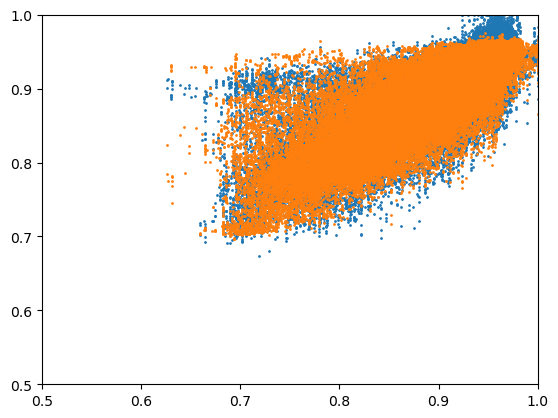

In [501]:
c = 11

_land_mask = land_mask[test_mask]
_snow_mask = snow_mask[test_mask]
_ice_mask = ice_mask[test_mask]

# plt.scatter(Y_test[_land_mask,c], _lin_p_test[_land_mask,c], s=1)
# plt.scatter(Y_test[_snow_mask,c], _lin_p_test[_snow_mask,c], s=1)
plt.scatter(Y_test[:,c], _lin_p_test[:,c], s=1)
# plt.scatter(Y_test[_ice_mask,c], _lin_p_test[_ice_mask,c], s=1)
plt.scatter(Y_test[:,c], _gbrt_p_test[:,c], s=1)
# plt.scatter(Y_test[:,c], _nn_p_test[:,c], s=1)


plt.xlim(0.5, 1)
plt.ylim(0.5, 1)

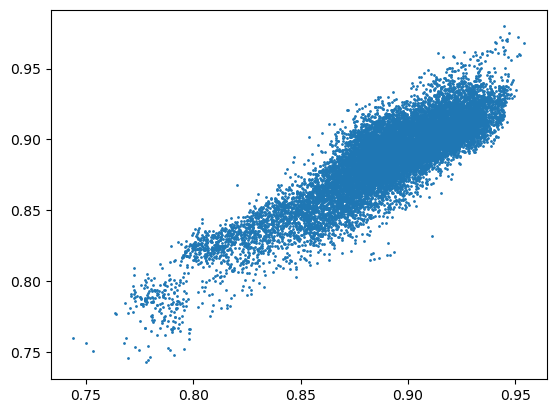

In [481]:
c = 9
plt.scatter(_nn_p_test[_ice_mask,c], _lin_p_test[_ice_mask,c], s=1)